In [1]:

### This will attempt to run randomise on LARGE data sets..
# coding: utf-8
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as niu
import nipype.interfaces.fsl as fsl
import os
import nibabel as nib
import scipy
import numpy as np
import glob
from scipy.sparse import coo_matrix
from numpy import genfromtxt
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, widgets

%matplotlib inline

In [ ]:
## Coordinate encoded sparse matrix...

#my_data[999]  ## numpy is y,x  or row by column

# ## CREATING A MASK
# mask A, B, C, D E and F
# most efficient way to get all NON ZERO's across all matrixes'
# Synthetic data sets--  want to have subject in one group and put in the UPPER LEFT CORNER
# BOTTOM RIGHT CORNER vs TOP LEFT CORNER
# display arrays in python larger than 4 x 4
# DO it very small

In [2]:
sampleDotFile = '/home/dagutman/data/WholeBrainMatrixConnectivity_downsample_4/Fox_C_fdt_matrix3_downsample_4.dot'
sparseCoordData = genfromtxt(sampleDotFile, delimiter='  ')

In [3]:
print sparseCoordData.shape

my_data = sparseCoordData
x_array = my_data[:,0]
y_array = my_data[:,1]
c_array = my_data[:,2]  

width=  int(x_array.max())  ## Must remember numpy is y,x not x,y
height = int(y_array.max())

## Coordinates are 1 indexed from the original file, but the created matrix is
## 0 indexed, so need to adjust accordingly
indexArray = y_array * (width+1) + x_array
indexArray = indexArray.astype(int)

# Create a placeholder array in the proper shape to hold the unsparsed data matrix
a = np.zeros( (1,   (width+1) * (height+1) ))

### Copy the connectivity numbers in a single operation using a linearly indexed Array
a[0,indexArray] = c_array

## Now reshape the array into height, width  since numpy is y,x ordered
a = np.reshape(a, (height+1, width+1))


(706568, 3)


(16, 329)


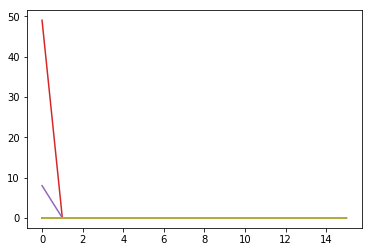

In [4]:
a[19,:].shape  ## this is currently a 1D array
b = np.reshape(a[19,:],(16,329))
# def showarray(a, fmt='png'):
#     a = np.int16(a)
#     ## was uint
#     f = StringIO()
#     PIL.Image.fromarray(a).save(f, fmt)
#     IPython.display.display(IPython.display.Image(data=f.getvalue()))
print b.shape
# showarray(b)
plt.plot(b)
plt.show()

In [5]:
def convertDotFileToNifti( dotFileIn, NIIout, reShapeByPofTwo=False, debug=False):
    ### Eventually instead of outputting a linear gigantic X,Y matric I am going to reshape
    ### it and take advantage of the z Plane
    ## This is a sparsely encoded matrix of X by Y by Connectivity generated by probtrackX
    sparseCoordData = genfromtxt(sampleDotFile, delimiter='  ')
    
    ## Split out the X, Y and C values from the dot file
    x_array = sparseCoordData[:,0]
    y_array = sparseCoordData[:,1]
    c_array = sparseCoordData[:,2]   ## Connectivity strength matrix
    
    width=  int(x_array.max())  ## Must remember numpy is y,x not x,y
    height = int(y_array.max())

    ## Coordinates are 1 indexed from the original file, but the created matrix is
    ## 0 indexed, so need to adjust accordingly
    indexArray = y_array * (width+1) + x_array
    indexArray = indexArray.astype(int)

    if debug: print width,height,my_data.shape,a.shape
    
    # Create a placeholder array in the proper shape to hold the unsparsed data matrix
    a = np.zeros( (1,   (width+1) * (height+1) ))
    
    ### Copy the connectivity numbers in a single operation using a linearly indexed Array
    a[0,indexArray] = c_array
    
    ## Now reshape the array into height, width  since numpy is y,x ordered
    a = np.reshape(a, (height+1, width+1))

    ## probably a more efficient way to convert this from a 2D to a 3D array,
    
    if reShapeByPofTwo:
        niiMatrix = np.zeros((a.shape[0]/8,a.shape[1]/8,64))
        a = np.reshape(a,(5264/8,5264/8,64))
        niiMatrix = a ## Copy the data from A into the nifti matrix
        print "Reshaping Matrix"

    else:
        niiMatrix = np.zeros((a.shape[0],a.shape[1],1))  ## make this into a 3-D Matrix
        niiMatrix[:,:,0] = a ## Copy the data from A into the nifti matrix
    
    niiImg = nib.Nifti1Image(niiMatrix, np.eye(4))
    
    ### I need to reshape A as well
##    print np.reshape(testDiag, (4,4,4)).shape
    myNiiImg.to_filename(NIIout)
    print "File Saved!"
    return True

In [6]:
dotFiles = glob.glob('/home/dagutman/data/WholeBrainMatrixConnectivity_downsample_4/*.dot')
for df in dotFiles:
    print df
    convertDotFileToNifti( df, df+'.nii.gz',reShapeByPofTwo=True)

/home/dagutman/data/WholeBrainMatrixConnectivity_downsample_4/Fox_E_fdt_matrix3_downsample_4.dot
Reshaping Matrix


NameError: global name 'myNiiImg' is not defined

In [7]:
## _M denotes the returned data is a numpy  array

def dotFileToNParray( dotFileIn, npArrayType='int16'):
    sparseCoordData = genfromtxt(dotFileIn, delimiter='  ')
    
    ## Split out the X, Y and C values from the dot file
    srcId_M = sparseCoordData[:,0].astype(int)
    tgtId_M = sparseCoordData[:,1].astype(int)
    connectivity_M = sparseCoordData[:,2]   ## Connectivity strength matrix

    return srcId_M, tgtId_M, connectivity_M



In [23]:
src_id, tgt_id, connectivity = dotFileToNParray(sampleDotFile)

@interact(src=(0,src_id.max(),1), myOtra=(0,100,1),continuous_update=False)
def plot_connectivity(src,myOtra):
    src_index = src_id == src
    tgt_index = tgt_id == src
    
    tgt_index = myOtra
    print tgt_index
    
    x = np.append(src_id[tgt_index], tgt_id[src_index])
    
    y = np.append(connectivity[tgt_index], connectivity[src_index])
    plt.scatter(x,y)
    plt.ylim(0,tgt_id.max())
    plt.xlim(0,src_id.max())
    plt.axvline(x=src)
    plt.show()
    

interactive(children=(IntSlider(value=2631, description=u'src', max=5263), IntSlider(value=50, description=u'myOtra'), Output()), _dom_classes=('widget-interact',))

In [9]:
### Map coordinates back to initial data space... this requires the fdt_matrix3 file
matrixCoordIndexFile = "../SampleDataFiles/coords_for_fdt_matrix3" 
## The connectivity matrix is organived as src_id, tgt_id then connectivity
## the coords_for_fdt_matrix3 says src_id is equal to x,y,z,t values....

def getMatrixLabelMap2Coords( coordsTxtFile, ignoreTimeDim = True, debug=False):
    """This returns a dictionary that converts a label index to it's representative coordinate...
    and returns a MatrixFile, a Dict File and some stats """
    labelMap_M =   genfromtxt(coordsTxtFile, delimiter='  ').astype(int)
    if debug: print labelMap_M
    
    
    xMax, yMax, zMax = (labelMap_M[:,0].max(),labelMap_M[:,1].max(),labelMap_M[:,2].max())
    
    lblToCoords = {}

    for r in labelMap_M:
        #print r
        (x,y,z,t,lblIndex) = r
        if ignoreTimeDim:
            lblToCoords[lblIndex] = (x,y,z)
        else:
            lblToCoords[lblIndex] = (x,y,z,t)

            
    if debug: print xMax,yMax,zMax
    return {'M': labelMap_M, 'D': lblToCoords, "Mdescrip": (xMax,yMax,zMax) }

In [16]:
anatomicSpaceImg = np.zeros((100,100,100), dtype='int')


lblToAnatSpace = getMatrixLabelMap2Coords(matrixCoordIndexFile)

## To start I am just going to look at the src_id's to see "where" the connectivity matrices were computed from
src_id, tgt_id, connectivity = dotFileToNParray(sampleDotFile)

for srcPt in set(src_id):
    anatCoords =  lblToAnatSpace['D'][srcPt]
    anatomicSpaceImg[anatCoords] = 100
    
    
    


In [17]:


def multi_slice_viewer(volume):
    remove_keymap_conflicts({'r', 't'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'r':
        previous_slice(ax)
    elif event.key == 't':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [19]:
def interact_hookup(f, controls):
    from ipywidgets import Output
    from IPython.display import clear_output
    def observer(change):
        clear_output()
        kwargs = {k:v.value for k,v in controls.items()}
        f(**kwargs)
    for k,w in controls.items():
        w.observe(observer, 'value')
    observer(None)

w = dict(
      title=widgets.Text(value='Hello World', placeholder='Type something', description='Title:', disabled=False),
      display_trend=widgets.ToggleButton(value=False, description='Display Trend', icon='check'),
      marker=widgets.RadioButtons(options=['x', 'o', '.'], value='x', description='Marker:'),
      amplitude=widgets.FloatSlider(value=1, min=-5, max=5, description='Amplitude:'),
      step_size=widgets.FloatSlider(value=0.1, min=0.01, max=0.1, step=0.01, description='Step size:'),
      periods=widgets.FloatSlider(value=5, min=1, max=20, description='Periods:'),
      noise_scale=widgets.FloatSlider(value=0.1, min=0.01, max=2, description='Noise:'),
      offset=widgets.FloatSlider(value=0, min=-5, max=5, description='Offset:'),
      trend=widgets.FloatSlider(value=1, min=-5, max=5, description='Trend:'),
    )

UI = VBox([
        HBox([
                VBox([w['title'], w['display_trend'], w['marker'],]),
                VBox([w['amplitude'], w['step_size'], w['periods'], w['noise_scale'], w['offset'], w['trend'],])
            ]),
    ])

interact_hookup(makeplot, w)
display(UI)

NameError: name 'VBox' is not defined

In [20]:
a = widgets.FloatText()
b = widgets.FloatSlider()
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

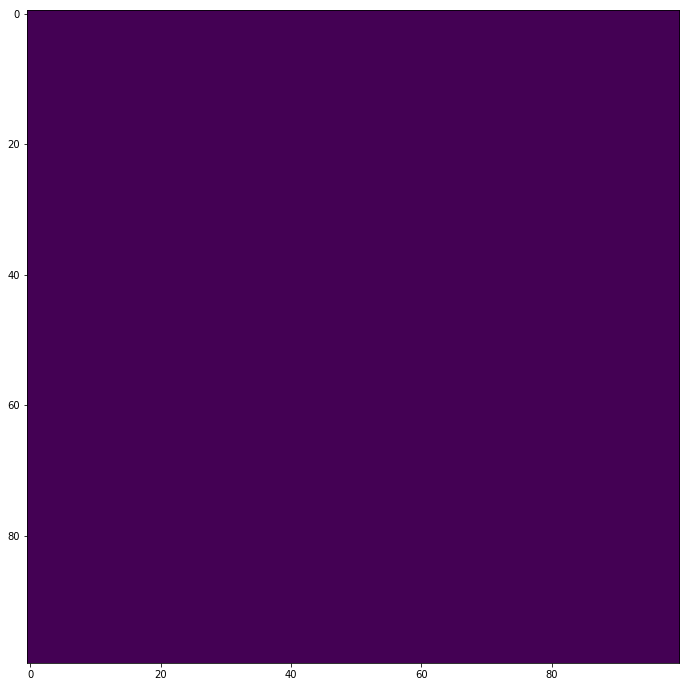

In [24]:
multi_slice_viewer(anatomicSpaceImg)

In [13]:
from ipywidgets import interact, fixed, widgets
plt.rcParams["figure.figsize"] = [14,12]

@interact(xSlice=(1,224,1))
def visualizeMatrixSlice( xSlice ):
    b = np.reshape(a[xSlice,:],(16,329))
    plt.imshow(b, cmap='jet')
    print xSlice
    #print "HI"
    return 
    
# interact(visualizeMatrixSlice,
#         xSlice=widgets.(options=range(1, 15), value=3, description='# of clusters:', disabled=True))

interactive(children=(IntSlider(value=112, description=u'xSlice', max=224, min=1), Output()), _dom_classes=('widget-interact',))

In [ ]:
#     plt.show()
    
#     km = KMeans(n_clusters=k)
#     km.fit(X)
#     cluster_labels = km.labels_ #each patient's corresponding cluster #
#     labels = list(set(cluster_labels)) #set of cluster numbers, e.g. 0 and 1 for k = 2
#     index = np.empty(shape=(0,0))
#     for label in labels:
#         idx = np.where(cluster_labels == label)[0]
#         index = np.append(index, idx)
#     D = squareform(pdist(X, 'euclidean'))
#     index = index.astype(int)
#     reordered_d = D[index,:][:,index] #reorganizes the data, patients within same cluster are together
#     plt.imshow(reordered_d, cmap='Greys_r')
#     plt.colorbar()
#     plt.figure()

## This will generate matrices that have been seeded with various ROIs so I can test the algorithm is working
# def plotSimplyArray(get_matrix_slice, fmt='png'):
#     # showarray(b)
#     plt.plot(get_matrix_slice)
#     plt.show()

In [ ]:
myArray = my_data
xy_array = myArray[:, :2]
v_array = myArray[:, 2]
### need to compute maxX, maxY
# calculate the linear  index of this i*whatever + j
a = np.zeroes( ())

In [ ]:
# def convertDotFileToNifti( dotFileIn, NIIout, reShapeByPofTwo=False, debug=False):
#     ### Eventually instead of outputting a linear gigantic X,Y matric I am going to reshape
#     ### it and take advantage of the z Plane
#     ## This is a sparsely encoded matrix of X by Y by Connectivity generated by probtrackX
#     sparseCoordData = genfromtxt(sampleDotFile, delimiter='  ')
    
#     ## Split out the X, Y and C values from the dot file
#     x_array = my_data[:,0]
#     y_array = my_data[:,1]
#     c_array = my_data[:,2]   ## Connectivity strength matrix
    
#     width=  int(x_array.max())  ## Must remember numpy is y,x not x,y
#     height = int(y_array.max())

#     ## Coordinates are 1 indexed from the original file, but the created matrix is
#     ## 0 indexed, so need to adjust accordingly
#     indexArray = y_array * (width+1) + x_array
#     indexArray = indexArray.astype(int)

#     if debug: print width,height,my_data.shape,a.shape
    
#     # Create a placeholder array in the proper shape to hold the unsparsed data matrix
#     a = np.zeros( (1,   (width+1) * (height+1) ))
    
#     ### Copy the connectivity numbers in a single operation using a linearly indexed Array
#     a[0,indexArray] = c_array
    
#     ## Now reshape the array into height, width  since numpy is y,x ordered
#     a = np.reshape(a, (height+1, width+1))

#     ## probably a more efficient way to convert this from a 2D to a 3D array,
    
#     if reShapeByPofTwo:
#         niiMatrix = np.zeros((a.shape[0]/8,a.shape[1]/8,64))
#         a = np.reshape(a,(5264/8,5264/8,64))
#         niiMatrix = a ## Copy the data from A into the nifti matrix
#         print "Reshaping Matrix"

#     else:
#         niiMatrix = np.zeros((a.shape[0],a.shape[1],1))  ## make this into a 3-D Matrix
#         niiMatrix[:,:,0] = a ## Copy the data from A into the nifti matrix
    
#     niiImg = nib.Nifti1Image(niiMatrix, np.eye(4))
    
#     ### I need to reshape A as well
# ##    print np.reshape(testDiag, (4,4,4)).shape
#     myNiiImg.to_filename(NIIout)
#     print "File Saved!"
#     return True

In [ ]:
# myArray = np.ones((100,100)) * 100
### Hot Spot is currently a square, starting at 0,0 to 10,10
from os.path import join as oj

subjsPerGroup = 10
imageMatrixWidth, imageMatrixHeight = ( 100, 100)  ##Size of the entire image

## Size of the ROIs I spike into the image
roiWidth,roiHeight = (10,10)

ctrlRoiStarts = [0,40]  ## Assuming squares and starting at the same x,y coordinate to make it easier for now
testRoiStarts = [60,80]

outputDir = 'randomiseInputMatrices'

# myArray[20:30,20:30] = 50
# myArray[70:80,70:80] = 50
# saveMatrixToNifti(myArray,"patient000.nii.gz")
# print myArray

### Output Control Subjects
ctrlSubjBaseImage = np.ones((imageMatrixWidth,imageMatrixHeight))
testSubjBaseImage = np.ones((imageMatrixWidth,imageMatrixHeight))


for roiStart in ctrlRoiStarts:
    print roiStart
    ctrlSubjBaseImage[roiStart:(roiStart+roiWidth),roiStart:(roiStart+roiWidth)]  = 300

for i in range(10):
    ptID = "Ctrl%02d" % i
    saveMatrixToNifti(ctrlSubjBaseImage,oj(outputDir,"ctrl%02d.nii.gz" % i))

### Output Test Subjects
for roiStart in testRoiStarts:
    testSubjBaseImage[roiStart:(roiStart+roiWidth),roiStart:(roiStart+roiHeight)]  = 300


for i in range(10):
    ptID = "Test%02d" % i
    saveMatrixToNifti(testSubjBaseImage,oj(outputDir,"test%02d.nii.gz" % i))
    
imageMaskArray = np.ones((imageMatrixWidth,imageMatrixHeight))
saveMatrixToNifti(imageMaskArray,oj(outputDir,'cohortImageMask.nii.gz'),addRandom=False)

In [ ]:
#Result Set:  It is not generating any results when the data is all 0's and has a single inserted layer with real data

### Need to generate a mask of all 1's
## Add in noise dimension as well
## gaussian will multiple by 100 just for the hell of it
showarray(testSubjBaseImage)
#testSubjBaseImage[20]

In [ ]:
def saveMatrixToNifti( numpyArray, NIIout, addRandom=True, copyTo3Stacks = True):
    ### Current I assume this is a 2D array, if it is not I will exit.. later on we can try dealing with 3/4 d arrays
#    print numpyArray.shape
    
    if len(numpyArray.shape) != 2:
        print "ERROR-- only works for 2D array input currently"
        sys.exit()
    (height,width)  = numpyArray.shape
    ##    backgroundMode = ['zeroes','gaussian']
    # Create a placeholder array in the proper shape to hold the unsparsed data matrix
    #a = np.zeros( (1,   (width) * (height) ))
    niiMatrix = np.zeros((height,width,3))  ## make this into a 3-D Matrix

    if addRandom:
        ### This will add a random Gaussian matrix to each input array
        noiseData = np.random.normal(scale=100,size=(height,width))
        niiMatrix[:,:,0] = noiseData + numpyArray ## Copy the data from A into the nifti matrix
    else:
        niiMatrix[:,:,0] = numpyArray 
        
    if copyTo3Stacks:
        niiMatrix[:,:,1] =  niiMatrix[:,:,0]
        niiMatrix[:,:,2] =  niiMatrix[:,:,0]
    
    niiImg = nib.Nifti1Image(niiMatrix, np.eye(4))
    
    ### I need to reshape A as well
    niiImg.to_filename(NIIout)
    return True

In [ ]:
### Input Data Sets consist of .dot files which we need to eventually convert into nifti files
# M is the "real" data with size 5263x5263

# Z=M*0; % creates 5263x5263 matrix of zeros
# N=cat(3,M,Z); % concatenate M and Z in the 3rd dimension
# > in matlab
# >
# > x=load('fdt_matrix3.dot');
# > M=full(spconvert(x));
# >
# > % reshape matrix into 3 dimensions - need to do math to find factors
# > B=reshape(M,64,529,17161);
# >
# > % need this toolbox -
# > https://www.mathworks.com/matlabcentral/fileexchange/8797-tools-for-nifti-and-analyze-image?focused=3806902&tab=function
# >
# > save('connectivity_matrix_nothr_reshape3d.mat','B','-v7.3');
# > nii=make_nii(B);
# > save_nii(nii,'connectivity_matrix_nothr_reshape3d.nii');
